# Singular Value Decomposition (SVD) for dimensionality reduction

## Introduction

The aim of this project is to predict the value of glucose content in the straw samples from the near-infrared spectroscopic measearements. In this report, Singular Value Decomposition (SVD) is performed to reduce the dimensionality of the dataset and the reduced dataset is introduced into random forest to predict the value of glucose content of the sample. 

This report is divided into multiple sessions, 
- Data preparation and exploration: the quality of the data is checked, explorative analysis is done and dimensionality reduction is applied in the session. 
- Model creation and evaluation: prediction models are created using 70 % of the data, tested the models on 30% of the data. The model evaluation metrics used are Mean Absolute Error, Root Mean Squared Error and R2 value.
- Conclusion: The results are summarised.


## Data preparation and exploration

In [2]:
## import necessary packages
import pandas as pd
from scipy.io import loadmat
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV



In [3]:
## load data
data_dict = loadmat('straw4latentix.mat')
data_array = data_dict['Data']

data = pd.DataFrame(data_array,
                  columns=data_dict['VarNames'],index=data_dict['SampleNames'] )
## remove missing data
data=data.dropna()
## remove spaces in the column names
data.columns = data.columns.str.replace(' ','')
data.shape


(805, 1051)

In [4]:
data.head()

,Glucose,400,402,404,406,408,410,412,414,416,...,2480,2482,2484,2486,2488,2490,2492,2494,2496,2498
S07-1-1--2,0.246511,0.524796,0.544383,0.563924,0.579351,0.592710,0.604313,0.613291,0.619849,0.625459,...,0.478467,0.480623,0.482462,0.484044,0.485346,0.486259,0.486837,0.487028,0.487021,0.486748
S07-2-1--2,0.262637,0.523378,0.542192,0.563364,0.577968,0.591923,0.604311,0.612846,0.619959,0.626117,...,0.484350,0.486585,0.488573,0.490205,0.491446,0.492375,0.493030,0.493293,0.493232,0.493023
S07-3-1--2,0.229592,0.490013,0.512134,0.533794,0.551275,0.565100,0.578490,0.587710,0.595307,0.602589,...,0.475923,0.478207,0.480053,0.481568,0.482865,0.483788,0.484375,0.484570,0.484543,0.484313
S07-4-1--2,0.230800,0.529905,0.551151,0.572237,0.589587,0.604449,0.617726,0.626785,0.634827,0.641014,...,0.478666,0.480832,0.482701,0.484350,0.485627,0.486568,0.487219,0.487499,0.487448,0.487216
S07-5-1--2,0.251905,0.511296,0.530461,0.551822,0.568217,0.581484,0.593503,0.602179,0.609293,0.615125,...,0.495099,0.497431,0.499412,0.501035,0.502360,0.503265,0.503873,0.504135,0.504092,0.503816


In [5]:
## check if there are missing data 
data.isnull().sum().sum()

0

count    805.000000
mean       0.225973
std        0.034042
min        0.141236
25%        0.199823
50%        0.229967
75%        0.251407
max        0.329025
Name: Glucose, dtype: float64

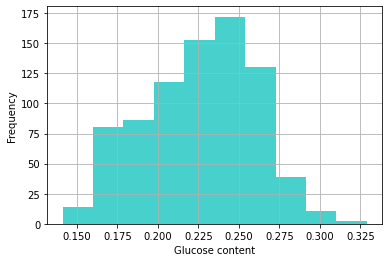

In [22]:
## histogram of the target variable

ax=data['Glucose'].hist(color='mediumturquoise')
ax.set_xlabel("Glucose content")
ax.set_ylabel("Frequency")
fig = ax.get_figure()
fig.savefig('glucose_hist')

## get descriptive statistics of the target column
data['Glucose'].describe()

In [36]:
## highly correlated variables (above 95%)
thr_val=0.95
high_cor = data.loc[:,'Glucose':].corr().unstack().reset_index()
high_cor=high_cor[(high_cor[0]>thr_val)&(high_cor[0]<1)]
high_cor

,level_0,level_1,0
1053,400,402,0.998538
1054,400,404,0.993737
1055,400,406,0.986622
1056,400,408,0.976602
1057,400,410,0.962912
...,...,...,...
1104595,2498,2488,0.999853
1104596,2498,2490,0.999890
1104597,2498,2492,0.999935
1104598,2498,2494,0.999967


In [9]:
## separate train and test data before SVD

##separate independent variables and target variable
X= data.loc[:,'400':]
y=data.loc[:,'Glucose']

## split train test data, 70:30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)



In [10]:
## do svd on train data and get the top 10 singular vectors

svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
svd.fit(X_train)

X_train_svd=svd.fit_transform(X_train, y=None)
X_train_svd.shape



(563, 10)

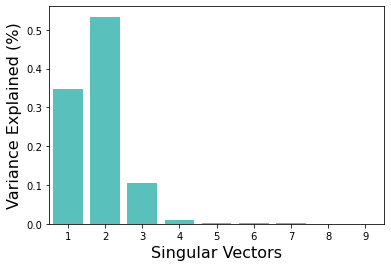

In [30]:
## variance explained by the first 10 singular vectors
var_explained = svd.explained_variance_ratio_
sns.barplot(x=list(range(1,10)),
            y=var_explained[:9], color='mediumturquoise')
plt.xlabel('Singular Vectors', fontsize=16)
plt.ylabel('Variance Explained (%)', fontsize=16)
plt.savefig('variance_expl')

In [24]:
## do the svd transformation on test data
X_test_svd=svd.transform(X_test)
X_test_svd.shape


(242, 10)

## Model creation and evaluation

In [25]:
## model evaluation metrics

def eval(actual,prediction):
    # Mean absolute error (MAE)
    mae = mean_absolute_error(actual, prediction)
    # Root mean squared error (RMSE)
    rmse = mean_squared_error(actual, prediction,squared=False)
    # R-squared scores
    r2 = r2_score(actual, prediction)
    # Print metrics
    return{'Mean Absolute Error': round(mae, 2),
          'Root Mean Squared Error': round(rmse, 2),
          'R-squared scores': round(r2, 2)}

### Randomforest model

In [40]:
rf = RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400,random_state=42)

## model using the original data (without dimensionality reduction)
rf.fit(X_train, y_train)
y_pred_rf_original = rf.predict(X_test)

# formatting results
result_df = pd.DataFrame({'Actual': y_test.values, 'Predicted_nonreduced': y_pred_rf_original})


## evaluation metrics
print("\nPREDICTION: ")
eval(result_df['Actual'],result_df['Predicted_nonreduced'])




PREDICTION: 


{'Mean Absolute Error': 0.02,
 'Root Mean Squared Error': 0.02,
 'R-squared scores': 0.55}

In [42]:
## randomforest model using singular values from SVD
rf.fit(X_train_svd, y_train)
y_pred_rf_svd = rf.predict(X_test_svd)

# formatting results

result_df['Predicted_svd'] =y_pred_rf_svd


## evaluation metrics
print("\nPREDICTION: ")
eval(result_df['Actual'],result_df['Predicted_svd'])




PREDICTION: 


{'Mean Absolute Error': 0.02,
 'Root Mean Squared Error': 0.02,
 'R-squared scores': 0.63}

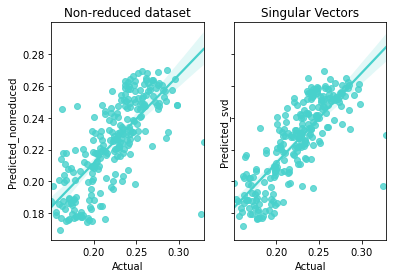

In [43]:
## plot the results of both models

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.regplot(x="Actual", y="Predicted_nonreduced", data=result_df, ax=ax1,color='mediumturquoise')
sns.regplot(x="Actual", y="Predicted_svd", data=result_df, ax=ax2,color='mediumturquoise')
ax1.set_title("Non-reduced dataset")
ax2.set_title("Singular Vectors")
fig.savefig('models')
